# Predicting Cardiovascular Disease: A Data-Driven Risk Assessment

## 1. Introduction 

Cardiovascular disease (CVD) is the leading cause of death globally, accounting for million deaths per year. Early identification of at-risk individuals can lead to timely intervention and save lives.  We can do this with data science, as we analyze a dataset with statistics that can indicate if someone has cardiovascular disease.  In our dataset, we collect stats and characteristics of thousands of patients.  We will use various classification algorithms (logistic regression, and ) to train on this data, and predict if someone is going to develop cardiovascular disease just from their characteristics.  

In this project, we analyze patient health metrics to:
- Understand key risk factors
- Build a predictive model for cardiovascular disease
- Provide actionable recommendations for healthcare decision-makers

This type of data work can directly assist health clinics, telemedicine providers, or insurance companies in managing population health more effectively.

Let's look at what columns the data has...


In [1]:
import pandas as pd
import numpy as np

heart_df = pd.read_csv('cardio_train.csv', delimiter = ';')

# number of rows
print("Number of patients in dataset: "+str(len(heart_df)))

heart_df.head(10)

Number of patients in dataset: 70000


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


We use an anonymized dataset of 70000 patient records, which have the following columns of data:

`age`, `gender` (1 male, 2 female), `height` (lbs), `weight` (inches), `ap_hi` (systolic BP), `ap_lo` (diastolic BP), `cholesterol`, `gluc`, `smoke`, `alco`, `active`, `cardio` (target: 1 = has cardiovascular disease, 0 = healthy)

The goals in this dataset will be to...

- Perform exploratory data analysis (EDA)  
- Identify top risk factors using visualization and feature importance  
- Train and evaluate classification models (Logistic Regression, Random Forest)  
- Translate findings into real-world policy recommendations

First let us represent the data with graphs to see what what kind of people we are dealing with in this dataset, then we will prepare it for predictions. 


## 2. Data Exploration

As always, with any kaggle dataset, we need to prepare and clean the data to help optimize visualizing the data.  In the next function **cleaner_df**, we will convert the `age` column into years (it is for sure being reported as days alive), and remove duplicates and NaNs.

In [2]:

def cleaner_df(df, map_names):
    
    df.columns = [col.capitalize() for col in df.columns]
    
    # remap column names
    df = df.rename(columns = {'Ap_hi':'Systolic BP', 'Ap_lo':'Diastolic BP', 'Gluc':'Glucose',
                              'Alco':'Alcohol Drinker', 'Active':'Inactive', 'Smoke': 'Smoker',
                              'Cardio':'CVD'})
    
    # create new column 
    df['Age'] = (df['Age'] / 365).astype(int)
    
    # there are no NaNs in this dataset, but I would count them and deal with them another way
    df = df.dropna()
    
    # in case there are some weird bloodpressure readings that could be errors
    df = df[(df['Systolic BP'] > 60) & (df['Systolic BP'] < 220)]
    df = df[(df['Diastolic BP'] > 30) & (df['Diastolic BP'] < 140)]
    
    # we reverse the value of 1 for Exerciser so that you are marked 1 if you don't exercise
    df['Inactive'] = abs(1-df['Inactive'])
    
    # create a BMI category
    df['BMI'] = df['Weight'] / (df['Height']/100)**2
    
    # make category columns for cholestorol and glucose
    df['Cholesterol Category'] = df['Cholesterol'].map(map_names)
    df['Glucose Category'] = df['Glucose'].map(map_names)

    # Check for missing data
    print("Missing values per column:\n", df.isna().sum())
    
    print("Total number of data points after cleaning: "+str(len(df)))
    
    return df

MAP_NAMES = {1: 'Normal', 2: 'Below Normal', 3: 'Well Below Normal'}

clean_heart_df = cleaner_df(heart_df, MAP_NAMES)


Missing values per column:
 Id                      0
Age                     0
Gender                  0
Height                  0
Weight                  0
Systolic BP             0
Diastolic BP            0
Cholesterol             0
Glucose                 0
Smoker                  0
Alcohol Drinker         0
Inactive                0
CVD                     0
BMI                     0
Cholesterol Category    0
Glucose Category        0
dtype: int64
Total number of data points after cleaning: 68691


Before performing any analysis or modeling, we cleaned the data to ensure quality and interpretability:

- **Converted age from days to years** for human-readable analysis. The original `age` column is in days, so we created a new column `age_years = age / 365`.

- **Calculated BMI** using height and weight to explore body composition as a factor:  
  `BMI = weight / (height in meters)^2`
  
- **Dropped duplicate entries** to avoid overrepresenting patients in the analysis.

- **Filtered out extreme blood pressure readings** (e.g., systolic < 80 or > 240) to reduce noise from erroneous inputs.

- **Mapped cholesterol and glucose codes** to readable categories:  
  `1 = normal`, `2 = above normal`, `3 = well above normal`

We also verified that there were **no missing values** in the dataset.  Due to the blood pressure filter we put in, 1307 data points were removed from the set.

Now we introduce our first graph, which is a stacked histogram showing the number of people that have cardiovascular disease 

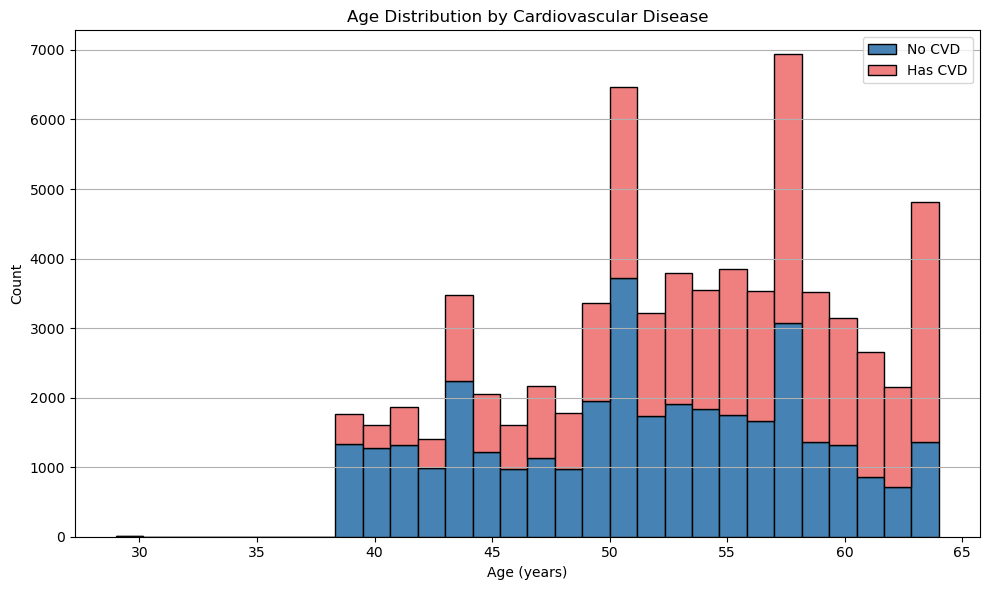

In [3]:
import matplotlib.pyplot as plt

def plot_age_histogram(df):
    plt.figure(figsize=(10, 6))
    
    # Split age groups
    age_no_cvd = df[df['CVD'] == 0]['Age']   # i do not have cardiovascular disease
    age_cvd = df[df['CVD'] == 1]['Age']      # i do have cardiovascular disease
    
    # Plot stacked histogram
    plt.hist([age_no_cvd, age_cvd], bins=30, stacked=True,
             label=['No CVD', 'Has CVD'], color=['steelblue', 'lightcoral'], edgecolor='black')
    
    plt.title('Age Distribution by Cardiovascular Disease')
    plt.xlabel('Age (years)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
plot_age_histogram(clean_heart_df)

This stacked histogram displays the age distribution of patients, separated by cardiovascular disease status:

- **Blue bars** represent patients **without** cardiovascular disease (CVD).

- **Red bars** represent patients **with** cardiovascular disease.

The x-axis shows age in years (converted from days in the original dataset), and the y-axis shows the **count of patients** in each age group.  The majority of patients are between **40 and 65 years old** with the incidence of cardiovascular disease increases significantly after age **50**, which is consistent with known medical trends.  There are **fewer younger patients (under 40)** in this dataset, and among them, CVD is relatively rare.  This distribution reinforces the importance of targeted screening and preventative care for older adults, especially those over 50.

The following code groups the dataset by **age group** and **gender** to calculate the **mean cardiovascular disease (CVD) rate** for each subgroup:

- Patients are binned into four age groups:  
  `<40`, `40–49`, `50–59`, `60–69`.
- Gender is mapped to **Male** and **Female** using the `gender` column.
- For each age-gender combination, we calculate the **percentage of patients with CVD** (`cardio = 1`).
- Finally, we plot a grouped bar chart showing how CVD prevalence changes by age and gender.

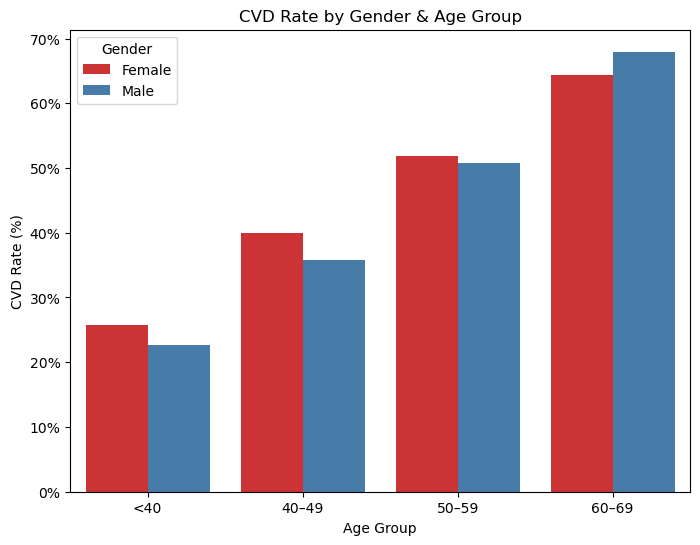

In [4]:
import seaborn as sns

def plot_gender_age_cvd(df):
   
    # age bins n' labels
    bins = [0, 39, 49, 59, 69]
    labels = ['<40', '40–49', '50–59', '60–69']
    
    # make age groups and gender labels
    df['Age Group'] = pd.cut(df['Age'], bins = bins, labels = labels, right = True)
    df['Gender Label'] = df['Gender'].map({1: 'Male', 2: 'Female'})
    
    # average out cvd rates per gender per age group
    cvd_rate = df.groupby(['Age Group', 'Gender Label'])['CVD'].mean().reset_index()
    
    plt.figure(figsize = (8,6))
    
    # seaborn over matplotlib this time
    sns.barplot(data = cvd_rate, x = 'Age Group', y = 'CVD', hue = 'Gender Label', palette = 'Set1')
    
    plt.ylabel('CVD Rate (%)')
    plt.xlabel('Age Group')
    plt.title('CVD Rate by Gender & Age Group')
    plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x*100:.0f}%')
    plt.legend(title = 'Gender')
    plt.show()
    
plot_gender_age_cvd(clean_heart_df)

We see the comparison of patients with CVD by gender across different age groups.  We clearly see that CVD risk increases with age for both genders, with men dominating in the age groups 60 and above.  The risk factor increases with age not gender.

The next bar graph shows the percentage of patients with CVD by BMI category:  The code bins each patient into a **BMI category** and calculates the percentage of patients with cardiovascular disease (CVD) in each group.  Remember that BMI is calculated as `weight (kg) / (height (m)^2)`.

The Patients are categorized into:  
  - Underweight: `<18.5`  
  - Normal weight: `18.5–24.9`  
  - Overweight: `25–29.9`  
  - Obese: `30+`

For each BMI category, we calculate the **CVD prevalence** (mean of `cardio = 1`).

$$\text{CVD Prevalence} = \frac{\text{Number of patients with CVD}}{\text{Total number of patients in the group}} \times 100 $$

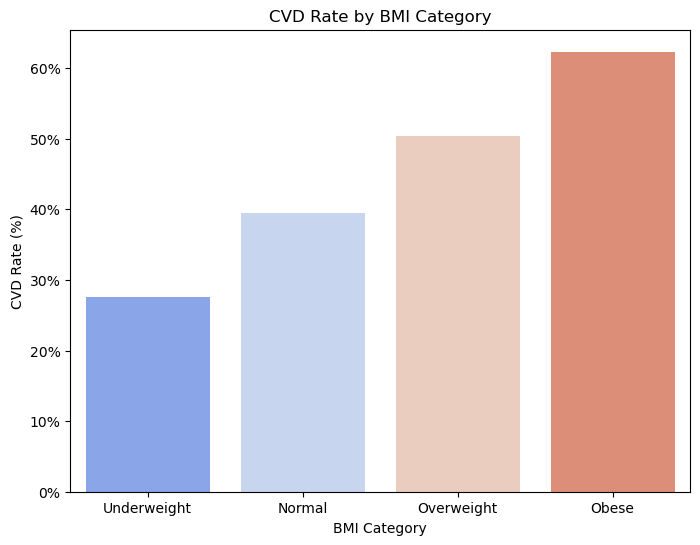

In [5]:

def plot_bmi_cvd(df):
    
    # bin the BMIs
    bins = [0, 18.5, 24.9, 29.9, 100]
    labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
    df['BMI Cat'] = pd.cut(df['BMI'], bins = bins, labels = labels)
    
    #
    bmi_rate = df.groupby('BMI Cat')['CVD'].mean().reset_index()
    
    plt.figure(figsize = (8,6))
    sns.barplot(data = bmi_rate, x = 'BMI Cat', y = 'CVD', palette = 'coolwarm')
    
    plt.ylabel('CVD Rate (%)')
    plt.xlabel('BMI Category')
    plt.title('CVD Rate by BMI Category')
    plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x*100:.0f}%')
    plt.show()
    
    
plot_bmi_cvd(clean_heart_df)

We see that the CVD prevalence **increases with BMI**, with obese individuals having the highest rates.  Underweight individuals show lower CVD prevalence, but the smallest sample size may limit insight.  More or less, we see that obesity increases CVD risk.

Our next graph calculates the CVD risk per total number of risk factors.

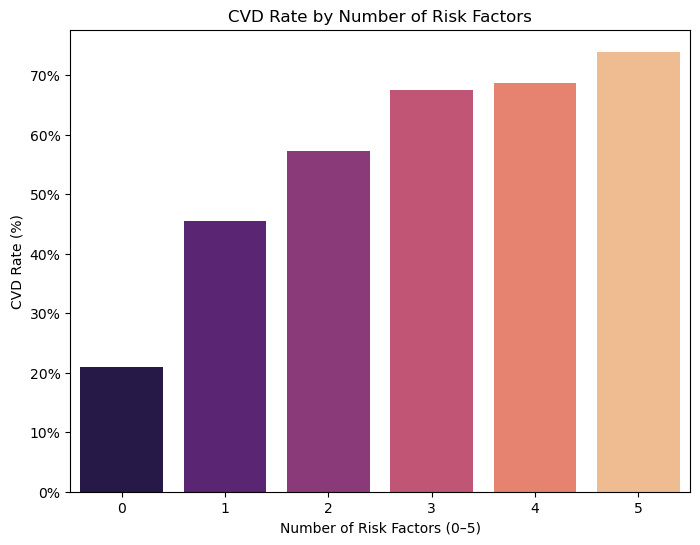

In [6]:

def plot_riskfactor_cvd(df):

    # Risk factors: smoke, inactive, high BP, high cholesterol, high glucose
    df['High Blood Pressure'] = ((df['Systolic BP'] >= 130) | (df['Diastolic BP'] >= 80)).astype(int)
    df['High Cholesterol'] = (df['Cholesterol'] > 1).astype(int)
    df['High Glucose'] = (df['Glucose'] > 1).astype(int)
    
    # Sum up totals for the risk count (ensure column names match your renamed columns)
    df['Risk Count'] = (df['Smoker'] + df['Inactive'] + df['High Blood Pressure'] + 
        df['High Cholesterol'] + df['High Glucose'])

    # Group and calculate CVD rate
    risk_rate = df.groupby('Risk Count')['CVD'].mean().reset_index()

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(data=risk_rate, x='Risk Count', y='CVD', palette='magma')

    # Clean x-axis and format
    plt.xticks(ticks=range(len(risk_rate['Risk Count'])), labels=risk_rate['Risk Count'])
    plt.ylabel('CVD Rate (%)')
    plt.xlabel('Number of Risk Factors (0–5)')
    plt.title('CVD Rate by Number of Risk Factors')
    plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x*100:.0f}%')
    plt.show()

plot_riskfactor_cvd(clean_heart_df)

The risk of CVD **rises sharply** with each additional risk factor.  Patients with **4 or 5 risk factors** have the highest CVD prevalence (over 70%).  This highlights the cumulative effect of lifestyle and clinical risk factors on heart health!

We will now use boxplots to compare **Systolic Blood Pressure (SBP)** and **Diastolic Blood Pressure (DBP)** distributions between patients **with CVD (`CVD = 1`)** and those **without CVD (`CVD = 0`)**.  The boxplot shows the **median**, **interquartile range (IQR)**, and **outliers** for each group.  This visualization is useful because blood pressure is a continuous variable, and we want to see how its distribution shifts depending on CVD status.  Blood pressure is an important risk factor for cardiovascular disease, and boxplots allow us to visualize **central tendency** (median) and **variability**, compare distributions directly between groups and detect **systematic differences** (e.g., higher blood pressure in the CVD group).


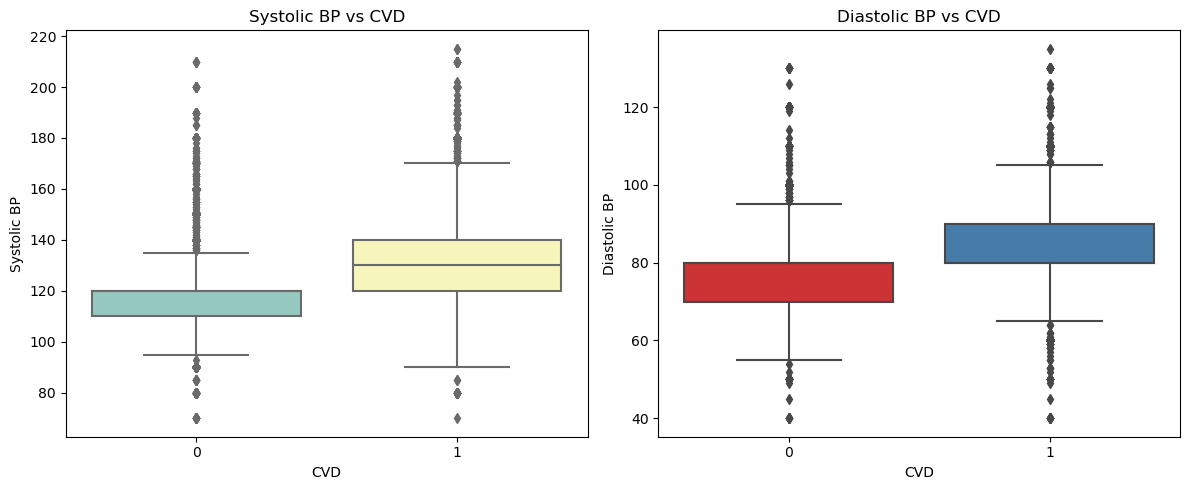

In [7]:

def plot_blood_pressure_box(df):

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(data = df, x = 'CVD', y = 'Systolic BP', palette = 'Set3')
    
    plt.title('Systolic BP vs CVD')
    plt.subplot(1, 2, 2)
    
    sns.boxplot(data = df, x = 'CVD', y = 'Diastolic BP', palette = 'Set1')
    
    plt.title('Diastolic BP vs CVD')
    plt.tight_layout()
    plt.show()
    
plot_blood_pressure_box(clean_heart_df)

Both **systolic** and **diastolic** blood pressure levels are generally **higher** in patients with CVD compared to those without.  The median SBP and DBP are shifted upward in the CVD group, suggesting that elevated blood pressure is strongly associated with cardiovascular disease.  The IQR (spread) is also slightly wider in the CVD group, meaning there is more variability in blood pressure among these patients.  Outliers are present in both groups, but are more common in the non-CVD group for SBP, which may indicate occasional isolated high readings not associated with diagnosed CVD.  These plots reinforce the established relationship between elevated blood pressure and cardiovascular disease risk. 

Next, the `plot_stacked_bar()` function generates **stacked bar charts** that show the proportion of patients with and without cardiovascular disease (CVD) within each category of a specific lab measurement:

1. **Descriptive Labels:** The function maps numeric codes (1, 2, 3) for glucose and cholesterol levels into human-readable labels (e.g., "Normal", "Above Normal", "Well Above").

2. **Cross-Tabulation:** Using `pd.crosstab()`, it calculates the percentage of patients in each `CVD` category (`0 = No CVD`, `1 = Has CVD`) for each level of the selected feature.

3. **Stacked Bar Chart:** Each bar shows the breakdown of CVD vs no CVD for each level of glucose or cholesterol.

This is an important plot because it shows how **CVD prevalence changes across biomarker categories**.  The graph is **percentage-based**, as it makes it easy to see trends even if sample sizes vary between categories.

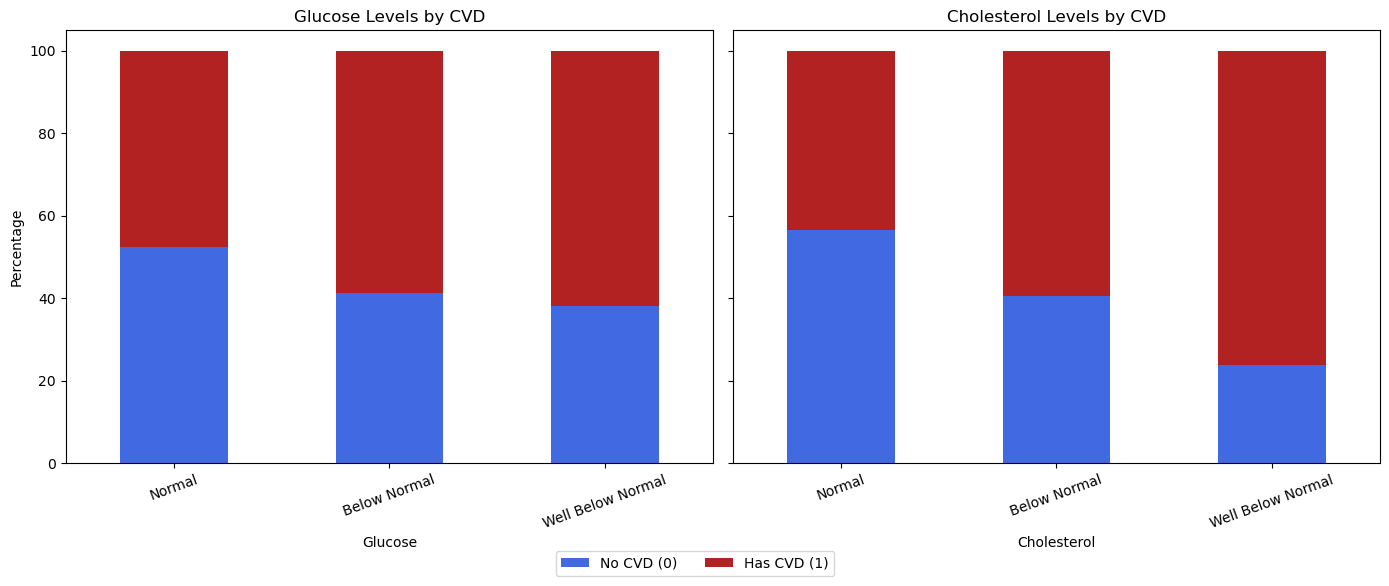

In [8]:
def plot_stacked_bar(df, label_map):
    
    df = df.copy()
    df['Glucose_Label'] = df['Glucose'].map(label_map)
    df['Cholesterol_Label'] = df['Cholesterol'].map(label_map)
    
    order = list(label_map.values())

    # Create cross-tabs
    glucose_tab = pd.crosstab(df['Glucose_Label'], df['CVD'], normalize = 'index') * 100
    chol_tab = pd.crosstab(df['Cholesterol_Label'], df['CVD'], normalize = 'index') * 100

    fig, axes = plt.subplots(1, 2, figsize = (14, 6), sharey = True)

    # Glucose subplot
    glucose_tab.loc[order].plot(kind = 'bar', stacked = True, ax = axes[0], color = ['royalblue', 'firebrick'])
    axes[0].set_title('Glucose Levels by CVD')
    axes[0].set_ylabel('Percentage')
    axes[0].set_xlabel('Glucose')
    axes[0].set_xticklabels(order, rotation = 20)
    axes[0].get_legend().remove()  # remove legend from subplot

    # Cholesterol subplot
    chol_tab.loc[order].plot(kind = 'bar', stacked = True, ax = axes[1], color = ['royalblue', 'firebrick'])
    axes[1].set_title('Cholesterol Levels by CVD')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('Cholesterol')
    axes[1].set_xticklabels(order, rotation = 20)
    axes[1].get_legend().remove()  # remove legend from subplot

    # Shared legend at the bottom
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, ['No CVD (0)', 'Has CVD (1)'],
               loc = 'lower center', ncol = 2, bbox_to_anchor = (0.5, 0.02))

    plt.tight_layout(rect = [0, 0.05, 1, 1])
    plt.show()

plot_stacked_bar(clean_heart_df, MAP_NAMES)

This combined stacked bar chart compares the percentage of patients with and without cardiovascular disease (CVD) across different levels of **glucose** and **cholesterol**:  The labels on the x axis correspond to the same labels from earlier in this section for the **cholesterol** and **glucose** rankings (1 = normal, 2 = below normal, 3 = well below normal). For both **glucose** and **cholesterol**, the proportion of patients with CVD **increases as levels rise**.  The **"Well Below" cholesterol group** shows the most dramatic difference, with nearly **75% of patients having CVD**.  Patients with **normal biomarker levels** have a lower CVD prevalence, though a substantial proportion are still affected.  So as we can see, elevated glucose and cholesterol levels are strongly associated with a higher prevalence of cardiovascular disease. This reinforces the importance of managing these biomarkers as part of CVD prevention strategies.

Our last graph will be a violin (manta ray) graph to show the weight distribution for patients with and without CVD.  A **violin plot** is ideal for showing the distribution of a continuous variable (like weight) across different categories (CVD vs no CVD). It combines the features of a boxplot and a kernel density estimate.  The **width** of each violin shows the **density** of observations at different values.  The **box** inside represents the interquartile range (IQR) and the median.  This gives a more complete picture of the data distribution compared to a boxplot alone, highlighting multimodality or skewness.

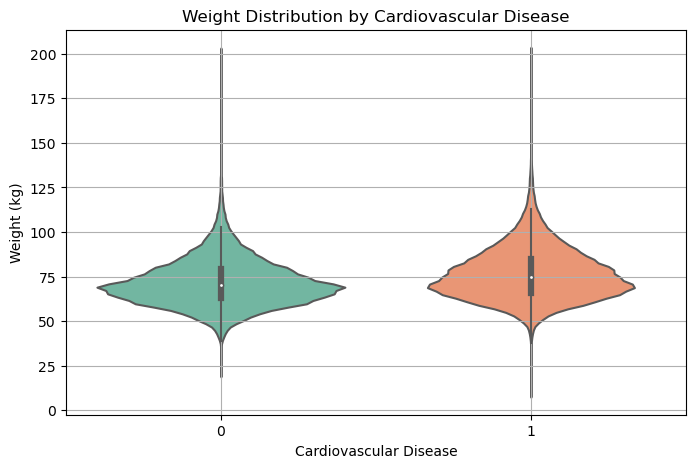

In [9]:

def plot_violin_weight(df):
    
    plt.figure(figsize = (8, 5))
    sns.violinplot(data = df, x = 'CVD', y = 'Weight', palette = 'Set2')
    plt.title('Weight Distribution by Cardiovascular Disease')
    plt.xlabel('Cardiovascular Disease')
    plt.ylabel('Weight (kg)')
    plt.grid(True)
    plt.show()
    
plot_violin_weight(clean_heart_df)

The shapes of the violins display how weight is distributed for each group.  Patients **with CVD** tend to have a slightly higher weight distribution.  The median weight and the spread of weights are greater in the CVD group compared to the non-CVD group.  There are some extreme outliers (very low and very high weights) visible as narrow tips.

In this section, we analyzed several features from the dataset to better understand their relationship with **cardiovascular disease (CVD)**:  
- **Demographics:** Age and gender distributions clearly showed that CVD prevalence increases with age.  
- **Biomarkers & Lifestyle:** Elevated cholesterol, glucose, blood pressure, and BMI were all strongly associated with higher CVD rates.  
- **Risk Factor Counts:** CVD prevalence rose sharply as patients accumulated more risk factors.  
- **Distribution Analysis:** Continuous variables like weight and blood pressure displayed clear differences in distribution between CVD and non-CVD groups.

These insights guide us in selecting features and transforming the dataset for predictive modeling.  In the next section we are going to use various algorithms to build predictive models that can use our data to determine if a new patient is at risk for CVD

## 3.  Creating a Predictive Model for CVD Using Logistic Regression

LogisticRegression from scikit-learn is a supervised machine learning algorithm used for binary and multiclass classification problems. Instead of predicting continuous values like linear regression, it estimates the probability that a data point belongs to a particular class using the logistic (sigmoid) function.  In logistic regression we model the linear score with

$$ z = \beta_0 + \beta^{T}x = \beta_0 + \sum^d_{j=1}\beta_j x_j $$

where
$\beta_0 = $ is the intercept (a single scalar). It shifts the decision boundary left/right.
$\beta_j = $ is the coefficent vector of length d.  Each $\beta_j$ weighs every $x_j$
$x_j = $ is the feature vector for one row (one patient), which also has length d

We map $z$ to a probability with the sigmoid:

$$ \sigma(z) = \frac{1}{1+e^{-z}} $$

so $p(y = 1∣x) = \sigma(z)$. In practice we choose a threshold (often 0.5, or tuned) to convert probabilities into class labels.

In a binary classification setup (e.g., predicting cardiovascular disease CVD or not), the model outputs probabilities between 0 and 1, and a threshold (usually 0.5) is used to assign class labels. Logistic Regression also supports regularization (via the C and penalty parameters) to prevent overfitting, and multiple optimization algorithms (defined by the solver parameter) for flexibility and scalability.  This makes LogisticRegression a great baseline model that is interpretable, fast to train, and performs well on structured/tabular data.

The model is only as good as its inputs.  In order to optimize the results and create the best predictive model for this dataset, we need to send the most impactful categories to **logisticRegression**.  Below we (1) remove implausible measurements, (2) derive physiologically meaningful features, and (3) add a few compact interactions that performed well in diagnostics.  The following function will create new metrics such as "Mean Arterial Pressure" `MAP`, and "Hypertention Stage" `HTN`, as well as clean the data in order to maximize the precision of the **logisticRegression** model.

In [10]:
def logreg_prep(df):

    # basic filters to remove weird outliers
    df = df[(df['Height'].between(130, 220)) & (df['Weight'].between(35, 180))]
    df = df[(df['Systolic BP'].between(80, 250)) & (df['Diastolic BP'].between(40, 140))]
    df = df[df['Systolic BP'] > df['Diastolic BP'] + 5]    
    df = df[df['BMI'].between(15, 55)]

    # create high blood pressure column
    df['High_BP'] = ((df['Systolic BP'] >= 130) | (df['Diastolic BP'] >= 80)).astype(int)

    # pulse pressure
    df['PulsePressure'] = df['Systolic BP'] - df['Diastolic BP']
    
    # mean arterial pressure
    df['MAP'] = df['Diastolic BP'] + df['PulsePressure'] / 3.0

    # hypertension stage (0,1,2)
    df['HTN_Stage'] = 0
    df.loc[(df['Systolic BP'] >= 130) | (df['Diastolic BP'] >= 80), 'HTN_Stage'] = 1
    df.loc[(df['Systolic BP'] >= 140) | (df['Diastolic BP'] >= 90), 'HTN_Stage'] = 2

    # obese
    df['Obese'] = (df['BMI'] >= 30).astype(int)
    
    # decade of age
    #df['AgeDecade'] = (df['Age'] // 10).astype(int)

    # high signal combinations
    df['AgeXBP']  = df['Age'] * df['High_BP']
    df['BMIGluc'] = df['BMI'] * df['Glucose']
    
    # Risk count: Counts how many risk indicators are present (monotonic with risk)
    df['RiskCount'] = (
        (df['Smoker'] == 1).astype(int) +
        (df['Inactive'] == 1).astype(int) +
        (df['Cholesterol'] > 1).astype(int) +
        (df['Glucose'] > 1).astype(int) +
        (df['Obese'] == 1).astype(int) +
        df['High_BP']
    )

    return df

With the dataframe all cleaned up we can plug them into our **LogisticRegression** fron **sklearn**.  The following **LogisticRegression** will quickly create a baseline model by:

1. Create train/val/test splits: Our target column is the 'CVD' column.  When we split the data we set the test size at 20% (0.20) (which gives us a test data size of ~13,000 after filtering) and we `stratify` the target column to make sure the classes are balanced in each split.  We run hyperparameter search using cross-validation on the training split and reserve the validation split to choose the operating threshold (e.g., by balanced accuracy). The test split remains untouched for final reporting.

2. Standardize features for LR: We use a standard scaler on the trained dataset and apply it to the test and validation set which will prevent leakage (we don't want the test and validation set influencing the trained set)  The scaler is one of many things nestled in the pipeline.

3. Build a pipeline: The pipeline contains all of the processes that will be used when we cross-validate the data.  We implanted the scaler in the pipeline with the parameters we are going to cross-validate over.  We selected an `l2` penalty as it shrinks all coefficients smoothly instead of zeroing some of the values (whih is what `l1` does), which is helpful when you have interactions and correlated vitals (Age, BP, MAP, PulsePressure).  The solver we pair with `l2` is an `lgbfs` which is fast, robust for `l2`, and handles thousands of samples and features well.  As for class weight, pretesting the algorithm showed that `None` and `balanced` didn't affect the ROC-AUC.

4. Create the Cross-Validation function with a randomized search: For finding our best value of C we use **RandomizedSearchCV** on a log space distribution for C.  Time wise, it is much cheaper for similar gains: with a few influential hyperparameters, random search finds strong configs with far fewer evaluations.  We leave `n_iter` at 100 and `cv` (the number of folds) at 10 to make sure our randomizedSearch finds that best value.

5. Begin the fit and find the best parameters and operating threshold: In this code we use three different thresholds

    """
    Return three validation thresholds:
      - thr_sens: smallest threshold achieving target TPR (recall)
      - thr_f1:   threshold that maximizes F1 on validation
      - thr_bacc: threshold that maximizes balanced accuracy on validation
    """

 """Compute common metrics at a given threshold (plus threshold-free AUC)."""

3. tune only the regularization strength C via randomized search with ROC-AUC
4. pick an operating threshold on the validation set by balanced accuracy
5. report test metrics, ROC, and a confusion matrix.

The descriptions for the code may be more detailed than expected, so that it can be proved that the person writing this code (me) understands what is going on in the algorithm.




In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, precision_recall_curve,
    balanced_accuracy_score, ConfusionMatrixDisplay
)
from scipy.stats import loguniform


# threshold function, we set target at .9
def pick_thresholds(y_val, p_val, target_tpr):

    # ROC-based arrays (for sensitivity/BAcc)
    fpr, tpr, thr = roc_curve(y_val, p_val)

    # Sensitivity-targeted
    idx = np.where(tpr >= target_tpr)[0]
    thr_sens = float(thr[idx[0]]) if len(idx) else 1.0  # fallback if impossible

    # Balanced Accuracy max
    bacc = (tpr + (1 - fpr)) / 2.0
    thr_bacc = float(thr[int(np.argmax(bacc))])

    # F1-maximizing
    prec, rec, thr_pr = precision_recall_curve(y_val, p_val)
    f1_arr = 2 * prec * rec / (prec + rec + 1e-12)
    thr_f1 = float(thr_pr[int(np.nanargmax(f1_arr))])

    return dict(thr_sens = thr_sens, thr_f1 = thr_f1, thr_bacc = thr_bacc)


def metrics_at_threshold(y_true, p_scores, thr):
   
    yhat = (p_scores >= thr).astype(int)
    return dict(
        threshold=float(thr),
        auc=float(roc_auc_score(y_true, p_scores)),
        accuracy=float(accuracy_score(y_true, yhat)),
        precision=float(precision_score(y_true, yhat)),
        recall=float(recall_score(y_true, yhat)),
        f1=float(f1_score(y_true, yhat)),
        bacc=float(balanced_accuracy_score(y_true, yhat)),
        report=classification_report(y_true, yhat, digits=3)
    )


# main function for training
def logreg_main(df, features, target)
                                n_iter=50, cv=5, target_tpr=0.90,
                                plot=True):
    # train test and split 
    X = df[features]
    y = df['CVD']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.20, random_state = 15
    )
    
    # split the trained set for validation set
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, stratify = y_train, test_size = 0.15, random_state = 15
    )

    # create pipeline for model to enter into gridsearch
    # the scaling is done inside the pipeline to prevent leakage
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            penalty = 'l2',
            solver = 'lbfgs',
            max_iter = 10000,
            class_weight = None,
            random_state = 15
        ))
    ])

    # RandomizedSearch
    param_dist = {'clf__C': loguniform(1e-3, 1e2)}
    search = RandomizedSearchCV(
        pipe, param_dist, n_iter = 100, cv = 10,
        scoring = 'roc_auc', n_jobs = -1, random_state = 15
    )
    
    search.fit(X_tr, y_tr)
    best = search.best_estimator_
    print("Logistic Regression (L2) best params:", search.best_params_)

    #
    p_val = best.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, p_val)
    th = pick_thresholds(y_val, p_val, target)
    print(f"Validation AUC={val_auc:.3f} | thresholds: "
          f"sens@TPR≥{target_tpr:.2f}={th['thr_sens']:.3f}, "
          f"F1-max={th['thr_f1']:.3f}, "
          f"BAcc-max={th['thr_bacc']:.3f}")

    # --- 4) test metrics at each threshold ---
    p_test = best.predict_proba(X_test)[:, 1]
    test_sens = metrics_at_threshold(y_test, p_test, th['thr_sens'])
    test_f1   = metrics_at_threshold(y_test, p_test, th['thr_f1'])
    test_bacc = metrics_at_threshold(y_test, p_test, th['thr_bacc'])  # reference

    print("\n📊 Test @ Sensitivity-targeted threshold")
    for k, v in test_sens.items():
        if k != 'report': print(f"{k:>10}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")
    print(test_sens['report'])

    print("\n📊 Test @ F1-max threshold")
    for k, v in test_f1.items():
        if k != 'report': print(f"{k:>10}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")
    print(test_f1['report'])

    print("\n(Reference) 📊 Test @ BAcc-max threshold")
    for k, v in test_bacc.items():
        if k != 'report': print(f"{k:>10}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")
    print(test_bacc['report'])

    # --- 5) plots (ROC and two confusion matrices) ---
    if plot:
        # ROC on test (threshold-free)
        fpr_t, tpr_t, _ = roc_curve(y_test, p_test)
        plt.figure(figsize=(7, 6))
        plt.plot(fpr_t, tpr_t, label=f'LR (L2) AUC={roc_auc_score(y_test, p_test):.3f}')
        plt.plot([0, 1], [0, 1], '--', color='grey')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title('ROC — L2 Logistic (test)'); plt.legend(); plt.show()

        # Confusion matrices for sensitivity-targeted and F1-max thresholds
        for name, thr_use in [('Sens threshold', th['thr_sens']),
                              ('F1-max threshold', th['thr_f1'])]:
            y_hat = (p_test >= thr_use).astype(int)
            ConfusionMatrixDisplay.from_predictions(
                y_test, y_hat, display_labels=['No CVD', 'CVD'], cmap='Blues'
            )
            plt.title(f'Confusion Matrix — {name} (thr={thr_use:.2f})')
            plt.show()

    # Pack results
    results = {
        'val_auc': float(val_auc),
        'thresholds': th,
        'test_at_sens': test_sens,
        'test_at_f1': test_f1,
        'test_at_bacc': test_bacc
    }
    # expose scaler if you want it explicitly
    fitted_scaler = best.named_steps['scaler']

    return best, fitted_scaler, results


COLUMNS = [
    'Age','BMI','Cholesterol','Glucose',
    'High_BP','AgeXBP','BMIGluc',
    'PulsePressure','MAP','HTN_Stage','Obese','RiskCount'
]

logreg_df = logreg_prep(clean_heart_df)

BEST_PIPE, SCALER, RESULTS = logreg_main(logreg_df, COLUMNS, 0.9)


LR (L2) best params: {'clf__C': 0.029338390208487924}
Best val threshold (balanced acc): 0.484 | Val AUC=0.788
Test Metrics — Simple L2 Logistic
ROC-AUC : 0.792
Accuracy: 0.729
Precision: 0.755
Recall   : 0.668
F1       : 0.709
              precision    recall  f1-score   support

           0      0.708     0.788     0.746      6920
           1      0.755     0.668     0.709      6770

    accuracy                          0.729     13690
   macro avg      0.731     0.728     0.727     13690
weighted avg      0.731     0.729     0.728     13690



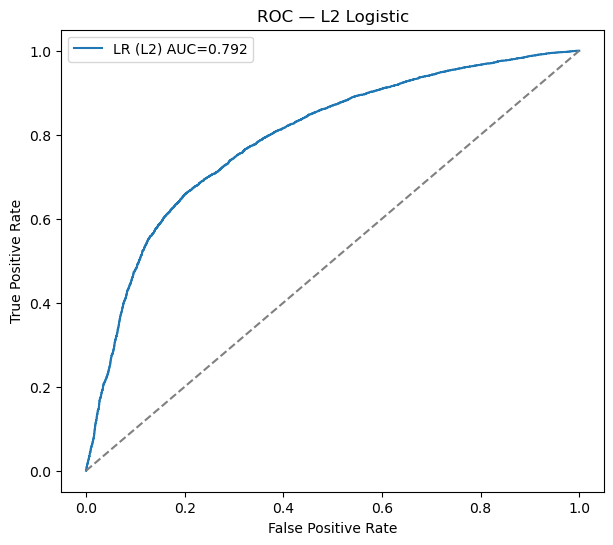

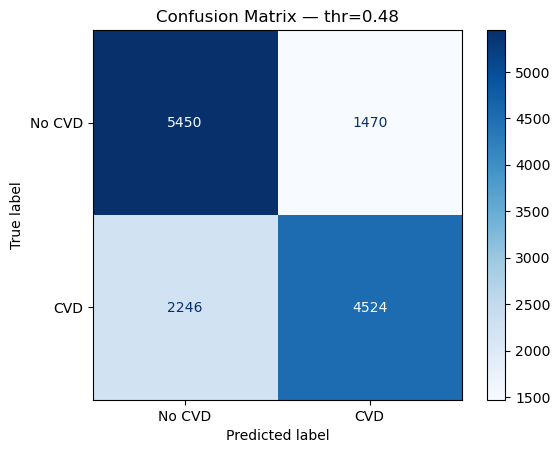

ValueError: not enough values to unpack (expected 4, got 3)

In [16]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, balanced_accuracy_score,
    ConfusionMatrixDisplay
)
from scipy.stats import loguniform

def run_simple_logreg(df, features):

    # train test and split 
    X = df[features]
    y = df['CVD']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify = y, test_size = 0.20, random_state = 15
    )
    
    # split the trained set for validation set
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, stratify = y_train, test_size = 0.15, random_state = 21
    )

    # create pipeline for model to enter into gridsearch
    # the scaling is done inside the pipeline to prevent leakage
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            penalty = 'l2',
            solver = 'lbfgs',
            max_iter = 10000,
            class_weight = None,       # apparently invariant: both none and balanced work
            random_state = 15
        ))
    ])
    
    # RandomizedSearch
    param_dist = {'clf__C': loguniform(1e-3, 1e2)}
    search = RandomizedSearchCV(
        pipe, param_dist, n_iter = 100, cv = 10,             # logreg is a quick model, but using 100 and 10
        scoring = 'roc_auc', n_jobs = -1, random_state = 16  # can be preceived by some as overkill (1000 fits)
    )
    
    # fit the CV tuned pipeline on the trained data
    search.fit(X_tr, y_tr)
    best = search.best_estimator_
    print("Logistic Regression (l2 penalty) Best Parameters:", search.best_params_)

    # get the validation probabilities
    p_val  = best.predict_proba(X_val)[:, 1]
    
    # Build the ROC by sweeping thresholds on val scores between the val set and the predicted set
    fpr, tpr, thr = roc_curve(y_val, p_val)
    
    # 
    bacc = (tpr + (1 - fpr)) / 2.0
    j = int(np.argmax(bacc))
    thr_bacc = float(thr[j])
    print(f"Best val threshold (balanced acc): {thr_bacc:.3f} | Val AUC={roc_auc_score(y_val, p_val):.3f}")

    #
    p_test = best.predict_proba(X_test)[:, 1]
    y_pred = (p_test >= thr_bacc).astype(int)
    auc = roc_auc_score(y_test, p_test)

    print("Test Metrics — Simple L2 Logistic")
    print(f"ROC-AUC : {auc:.3f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
    print(f"F1       : {f1_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    # ROC curve
    fpr_t, tpr_t, _ = roc_curve(y_test, p_test)
    plt.figure(figsize = (7,6))
    plt.plot(fpr_t, tpr_t, label=f'LR (L2) AUC={auc:.3f}')
    plt.plot([0,1],[0,1],'--', color = 'grey')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC — L2 Logistic'); plt.legend(); plt.show()

    # confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
        display_labels=['No CVD','CVD'], cmap='Blues')
    plt.title(f'Confusion Matrix — thr={thr_bacc:.2f}'); plt.show()

    return best, thr_bacc, {
        'val_auc': roc_auc_score(y_val, p_val),
        'test_auc': auc
    }


COLUMNS = [
    'Age','BMI','Cholesterol','Glucose',
    'High_BP','AgeXBP','BMIGluc',
    'PulsePressure','MAP','HTN_Stage','Obese','RiskCount'
    ]

logreg_df = logreg_prep(clean_heart_df)

BEST, SCALER, THR_BACC, AUC = run_simple_logreg(logreg_df, COLUMNS)


## 4. Utilizing 

In [ ]:
def make_features(df):
    
    d = df.copy()

    # --- recompute BMI if missing ---
    if 'BMI' not in d.columns:
        d['BMI'] = d['Weight'] / (d['Height']/100.0)**2

    # --- plausibility filters (trim label noise/outliers) ---
    d = d[d['BMI'].between(15, 55)]
    d = d[d['Height'].between(130, 220)]
    d = d[d['Weight'].between(35, 180)]
    d = d[d['Systolic BP'].between(80, 250)]
    d = d[d['Diastolic BP'].between(40, 140)]
    d = d[d['Systolic BP'] > d['Diastolic BP'] + 5]

    # OPTIONAL: drop exact duplicate health records to reduce noise
    keys = ['Age','Height','Weight','Systolic BP','Diastolic BP',
            'Cholesterol','Glucose','Smoker','Alcohol Drinker','Inactive']
    d = d.drop_duplicates(subset=keys, keep='first')

    # core labels/flags
    d['High_BP'] = ((d['Systolic BP'] >= 130) | (d['Diastolic BP'] >= 80)).astype(int)
    d['Obese']   = (d['BMI'] >= 30).astype(int)

    # physiologic features
    d['PulsePressure'] = d['Systolic BP'] - d['Diastolic BP']
    d['MAP'] = d['Diastolic BP'] + d['PulsePressure'] / 3.0

    # HTN stage: 0 normal/elevated, 1 stage-1, 2 stage-2+
    d['HTN_Stage'] = 0
    d.loc[(d['Systolic BP'] >= 130) | (d['Diastolic BP'] >= 80), 'HTN_Stage'] = 1
    d.loc[(d['Systolic BP'] >= 140) | (d['Diastolic BP'] >= 90), 'HTN_Stage'] = 2

    # proven interactions
    d['AgeXBP']  = d['Age'] * d['High_BP']
    d['BMIGluc'] = d['BMI'] * d['Glucose']

    # compact risk count (ordinal)
    d['RiskCount'] = (
        (d['Smoker'] == 1).astype(int) +
        (d['Inactive'] == 1).astype(int) +
        (d['Cholesterol'] > 1).astype(int) +
        (d['Glucose'] > 1).astype(int) +
        d['High_BP']
    )

    return df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, classification_report, ConfusionMatrixDisplay

def train_lgbm_monotone(df, features, target='CVD', random_state=21):
    X = df[features].copy()
    y = df[target].astype(int).copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.20, random_state=random_state
    )
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, stratify=y_train, test_size=0.15, random_state=random_state
    )

    # +1 means prediction must be non-decreasing if this feature increases
    mono_map = {
        'Age': +1, 'BMI': +1, 'Cholesterol': +1, 'Glucose': +1,
        'High_BP': +1, 'AgeXBP': +1, 'BMIGluc': +1,
        'PulsePressure': +1, 'MAP': +1, 'HTN_Stage': +1,
        'Obese': +1, 'RiskCount': +1,
        'Smoker': +1, 'Inactive': +1, 'Alcohol Drinker': +1
    }
    monotone_cst = [mono_map[f] for f in features]

    try:
        import lightgbm as lgb
    except ImportError:
        raise ImportError("pip install lightgbm")

    clf = lgb.LGBMClassifier(
        objective='binary',
        n_estimators=5000,
        learning_rate=0.02,
        num_leaves=31,
        min_child_samples=60,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        class_weight=None,
        random_state=random_state,
        monotone_constraints=monotone_cst
    )

    clf.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    # pick threshold by balanced accuracy on val
    p_val = clf.predict_proba(X_val)[:,1]
    fpr, tpr, thr = roc_curve(y_val, p_val)
    bacc = (tpr + (1 - fpr)) / 2.0
    t_best = float(thr[int(np.argmax(bacc))])

    # test metrics
    p_test = clf.predict_proba(X_test)[:,1]
    y_pred = (p_test >= t_best).astype(int)
    auc = roc_auc_score(y_test, p_test)

    print(f"LGBM (monotone) — best_iter={clf.best_iteration_}, Val AUC={roc_auc_score(y_val,p_val):.3f}")
    print("\n📊 Test Metrics")
    print(f"ROC-AUC : {auc:.3f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
    print(f"F1       : {f1_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=3))

    # ROC
    fpr_t, tpr_t, _ = roc_curve(y_test, p_test)
    plt.figure(figsize=(7,6))
    plt.plot(fpr_t, tpr_t, label=f'LGBM (monotone) AUC={auc:.3f}')
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC — LightGBM (Monotone)'); plt.legend(); plt.show()

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
        display_labels=['No CVD','CVD'], cmap='Blues')
    plt.title(f'Confusion Matrix — thr={t_best:.2f}'); plt.show()

    return clf, t_best, auc

